In [1]:
cd("/home/jzh/Dropbox/Research/Data-driven_estimation_inverse_optimization/Experiments/InverseVIsTraffic")

In [2]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
    flow_car::Float64
    flow_truck::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64,freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0., 0., 0.)

Arc (constructor with 3 methods)

In [3]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  
polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) #separate for consts

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [4]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [5]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [6]:
function addResid(m, coeffs, ys_car, ys_truck, demands_car, demands_truck, arcs, scaling)
	@defVar(m, resid)
    @defVar(m, dual_cost)
	@defVar(m, dual_cost_car)
    @defVar(m, dual_cost_truck)
	@defVar(m, primal_cost)
    @defVar(m, primal_cost_car)
    @defVar(m, primal_cost_truck)

	@addConstraint(m, dual_cost_car == sum{demands_car[(s,t)] * (ys_car[(s,t), t] - ys_car[(s,t), s]), (s,t)=keys(demands_car)})  
    @addConstraint(m, dual_cost_truck == sum{demands_truck[(s,t)] * (ys_truck[(s,t), t] - ys_truck[(s,t), s]), (s,t)=keys(demands_truck)})  
    @addConstraint(m, dual_cost == dual_cost_car + dual_cost_truck)
    
	@addConstraint(m, primal_cost_car == sum{a.flow_car * 1.0 * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})
	@addConstraint(m, primal_cost_truck == sum{a.flow_truck * 1.1 * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})
    @addConstraint(m, primal_cost == primal_cost_car + primal_cost_truck)
                   
	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [7]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [8]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), 
			a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [9]:
function addNetworkCnsts(m, coeffs, demands_car, demands_truck, arcs, numNodes)
	@defVar(m, ys_car[keys(demands_car), 1:numNodes])
    @defVar(m, ys_truck[keys(demands_truck), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands_car)
			@addConstraint(m, ys_car[od, k[2]] - ys_car[od, k[1]] <= 1.0 * rhs)
		end
		for od in keys(demands_truck)
			@addConstraint(m, ys_truck[od, k[2]] - ys_truck[od, k[1]] <= 1.1 * rhs)
		end
	end
	return ys_car, ys_truck
end

addNetworkCnsts (generic function with 1 method)

In [10]:
#Read in the demand file

file = open("./data_original/SiouxFalls_trips.txt")

demands = Dict{(Int64,Int64), Float64}()
demands_car = Dict{(Int64,Int64), Float64}()
demands_truck = Dict{(Int64,Int64), Float64}()

s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand
                demands_car[(s,t)] = demand * .8
                demands_truck[(s,t)] = demand * .2
            end
        end
    end
end                
close(file)

In [11]:
#read in the arc files

arcs = Dict{(Int, Int), Arc}()
file = open("./data_original/SiouxFalls_net.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), 
                                              float(vals[3]), float(vals[5]))
end
close(file)

In [12]:
#read in the car flows

file = open("./data_original/flows_car_converge_1e-5.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow_car = float(vals[3])
end

close(file)

In [13]:
#read in the truck flows

file = open("./data_original/flows_truck_converge_1e-5.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow_truck = float(vals[3])
end

close(file)

In [14]:
#calculate the total flow on each link
for (s,t) in keys(arcs)
    arcs[(s,t)].flow = 1.0 * arcs[(s,t)].flow_car + 2.0 * arcs[(s,t)].flow_truck
end

In [15]:
##########
#Generate the simulated data
##########
numData = 1; sigma = .0

flow_data = Array(Float64, length(arcs), numData)
flow_data_car = Array(Float64, length(arcs), numData)
flow_data_truck = Array(Float64, length(arcs), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()
demand_data_car = Dict{(Int, Int), Array{Float64, 1}}()
demand_data_truck = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
            demand_data_car[odpair] = [demands_car[odpair], ]
            demand_data_truck[odpair] = [demands_truck[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
            push!(demand_data_car[odpair], demands_car[odpair])
            push!(demand_data_truck[odpair], demands_truck[odpair])
        end
    end
    
    flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_car[:, iRun] = [a.flow_car::Float64 for a in vArcs]
    flow_data_truck[:, iRun] = [a.flow_truck::Float64 for a in vArcs]
end

In [16]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys_car, ys_truck = addNetworkCnsts(m, coeffs, demands_car, demands_truck, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys_car, ys_truck, demands_car, demands_truck, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [17]:
#include("trafficCval.jl")using DataFrames, Resampling

##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys_car, ys_truck = addNetworkCnsts(m, coeffs, demands_car, demands_truck, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys_car, ys_truck, demands_car, demands_truck, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [18]:
arcs3 = arcs
arcs4 = arcs
arcs5 = arcs
arcs6 = arcs
coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

# deg = 3
deg = 3
c = 3.
lam = 1e-4

fcoeffs3 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs3)
coeffs_dict[(deg, c, lam)] = fcoeffs3

# deg = 4
deg = 4
c = 4.
lam = .1

fcoeffs4 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs4)
coeffs_dict[(deg, c, lam)] = fcoeffs4

# deg = 5
deg = 5
c = 5.
lam = .01

fcoeffs5 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs5)
coeffs_dict[(deg, c, lam)] = fcoeffs5

# deg = 6
deg = 6
c = 6.
lam = 1e-3

fcoeffs6 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs6)
coeffs_dict[(deg, c, lam)] = fcoeffs6

0.008709909752884312
0.00045665411158685165
0.0004374882081260916
0.0004721707283444512


7-element Array{Float64,1}:
  1.00098    
 -0.00609241 
  0.013088   
 -0.0132731  
  0.15692    
 -0.00179868 
  0.000184953

INFO: Loading help data...


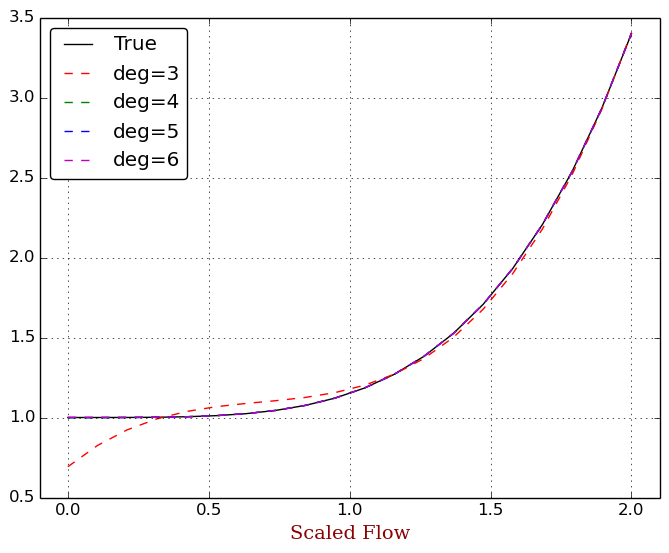

In [19]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]
fcoeffs3 = coeffs_dict[(3, 3., 1e-4)]
fcoeffs4 = coeffs_dict[(4, 4., .1)]
fcoeffs5 = coeffs_dict[(5, 5., .01)]
fcoeffs6 = coeffs_dict[(6, 6., 1e-3)]

xs = linspace(0, 2, 20)
ys_true = map(x->polyEval(true_coeffs, x), xs)
ys3 = map(x->polyEval(fcoeffs3, x), xs)
ys4 = map(x->polyEval(fcoeffs4, x), xs)
ys5 = map(x->polyEval(fcoeffs5, x), xs)
ys6 = map(x->polyEval(fcoeffs6, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys_true, "k", label="True")
plot(xs, ys3, "--r", label="deg=3")
plot(xs, ys4, "--g", label="deg=4")
plot(xs, ys5, "--b", label="deg=5")
plot(xs, ys6, "--m", label="deg=6")
legend(loc="upper left",fancybox="true") 
# plot(xs, ys, "--b")
grid("on")
xlim(-0.1, 2.1);
ylim(0.5, 3.5);

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("fitting.pdf")